In [4]:
from transformers import AutoTokenizer, AutoModel
import torch
from scipy.spatial.distance import cosine

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import json
import pandas as pd

In [19]:
import matplotlib.pyplot as plt #allows us to plot our results if desired
import seaborn as sns #also used for plotting data
import numpy as np
import os

# Comparing word embeddings
This approach to comparison is using word embeddings to determine the similarity between the ground truth abstract (from the JSON) and the parsed abstract.

Word embedding workflow and pre trained model sourced from the Hugging Face "transformers" library.

### Step one: create word embeddings for the abstracts

In [7]:
#step one: set up for creating embeddings-- loads pre-trained model.
model_name = "sentence-transformers/all-MiniLM-L6-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

In [8]:
#gets the embedding for each text.
def get_embedding(text):
    # first, tokenize
    tokens = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    # then get embeddings
    with torch.no_grad():
        outputs = model(**tokens)
        embeddings = outputs.last_hidden_state.mean(dim=1)
    return embeddings.squeeze().numpy()

In [9]:
#ground_text = "We show evidence of particle acceleration at GEV energies associated directly with protons from the prompt emission of a long-duration M6-class solar flare on July 17, 2023, rather than from protons acceleration by shocks from its associated Coronal Mass Ejection (CME), which erupted with a speed of 1342 km/s. Solar Energetic Particles (SEP) accelerated by the blast have reached Earth, up to an almost S3 (strong) category of a radiation storm on the NOAA scale. Also, we show a temporal correlation between the fast rising of GOES-16 proton and muon excess at ground level in the count rate of the New-Tupi muon detector at the central SAA region. A Monte Carlo spectral analysis based on muon excess at New-Tupi is consistent with the acceleration of electrons and protons (ions) up to relativistic energies (GeV energy range) in the impulsive phase of the flare. In addition, we present another two marginal particle excesses (with low confidence) at ground-level detectors in correlation with the solar flare prompt emission." #fill in with abstracts
ground_text = open("/home/jovyan/work/project1/llamaparsing/ground_abstracts/ground_abstract_2.md", "r").read()
parsed_text = open("/home/jovyan/work/project1/llamaparsing/abstractholder", "r").read()
#get embeddings 
ground_embedding = get_embedding(ground_text)
parsed_embedding = get_embedding(parsed_text)

Now, we have the word embeddings needed for comparisons. 

Note: Here, we've sourced the embeddings using the all-MiniLM-L6-v2 model from Hugging Face. In practice, it may make sense to use a more specialized model, such as one trained specifically on academic language.

### Step two: analyze similarities
In this case, we're using cosine similarity to assess the similarity between the two embeddings.

In [11]:
# get cosine similarity
similarity = 1 - cosine(ground_embedding, parsed_embedding)
similarity

np.float32(1.0)

In [15]:
scores = []
for i in range(1, 11, 1):
    gname = "/home/jovyan/work/project1/llamaparsing/ground_abstracts/ground_abstract_{ii}.md".format(ii = i)
    pname = "/home/jovyan/work/project1/llamaparsing/parsed_abstracts/parsed_abstract_{ii}.md".format(ii = i)
    ground = get_embedding(open(gname, "r").read())
    parsed = get_embedding(open(pname, "r").read())
    score = 1 - cosine(ground, parsed)
    print(score)
    scores.append(score)


1.0
1.0
0.99895763
0.99170643
1.0
0.8632379
0.9965302
1.0
0.94420195
1.0


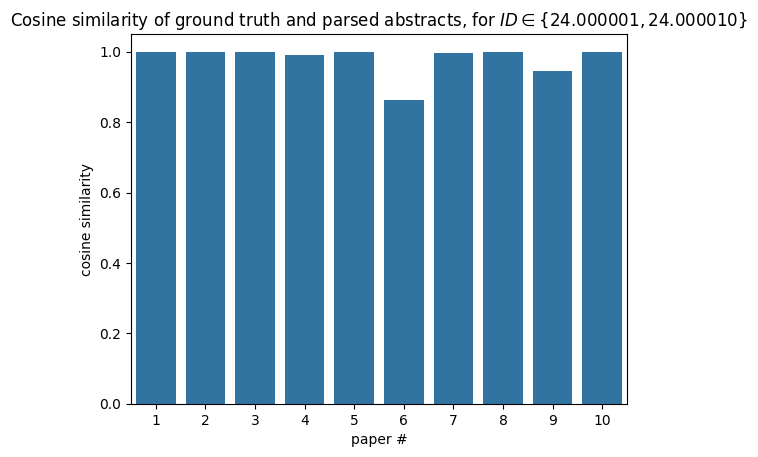

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111)

sns.barplot(x = range(1, 11, 1), y = scores)
plt.title('Cosine similarity of ground truth and parsed abstracts, for $ID\in\{24.000001, 24.000010\}$')
ax.set_xlabel('paper #')
ax.set_ylabel('cosine similarity')
plt.show()

In [21]:
print(np.average(scores))

0.9794634


In [16]:
agonist = get_embedding("This study utilized a D1-Like dopamine agonist to create the result")
antagonist = get_embedding("his study utilized a D1-Like dopamine receptor agonist to create the final product")
score = 1 - cosine(agonist, antagonist)
score

np.float32(0.8979103)

# Comparing by method

In [40]:
scores = []
filenames = []
parsers = []
ground = get_embedding("We show evidence of particle acceleration at GEV energies associated directly with protons from the prompt emission of a long-duration M6-class solar flare on July 17, 2023, rather than from protons acceleration by shocks from its associated Coronal Mass Ejection (CME), which erupted with a speed of 1342 km/s. Solar Energetic Particles (SEP) accelerated by the blast have reached Earth, up to an almost S3 (strong) category of a radiation storm on the NOAA scale. Also, we show a temporal correlation between the fast rising of GOES-16 proton and muon excess at ground level in the count rate of the New-Tupi muon detector at the central SAA region. A Monte Carlo spectral analysis based on muon excess at New-Tupi is consistent with the acceleration of electrons and protons (ions) up to relativistic energies (GeV energy range) in the impulsive phase of the flare. In addition, we present another two marginal particle excesses (with low confidence) at ground-level detectors in correlation with the solar flare prompt emission.")
for filename in os.listdir("/home/jovyan/work/project1/llamaparsing/comparisons"):
    f = os.path.join("/home/jovyan/work/project1/llamaparsing/comparisons", filename)
    parsed = get_embedding(open(f, "r").read())
    parsers.append(parsed)
    score = 1 - cosine(ground, parsed)
    print(filename)
    print(score)
    scores.append(score)
    filenames.append(filename)

pymu_pdf
1.0
open_parse
1.0
nougat
1.0
pdfplumber
0.9270256
pdfminer
1.0
llama
1.0


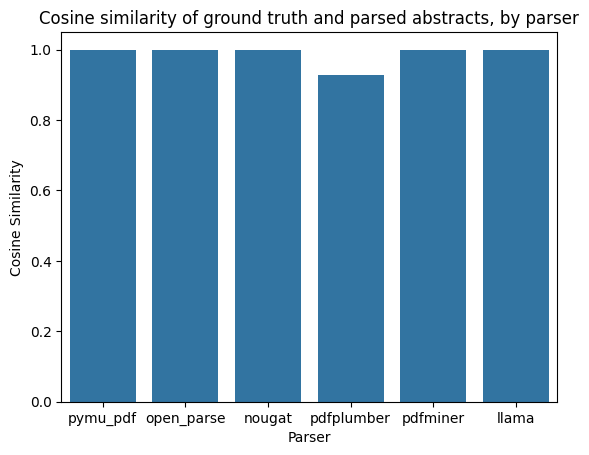

In [41]:
fig = plt.figure()
ax = fig.add_subplot(111)

sns.barplot(x = filenames, y = scores)
plt.title('Cosine similarity of ground truth and parsed abstracts, by parser')
ax.set_xlabel('Parser')
ax.set_ylabel('Cosine Similarity')
plt.show()

In [44]:
scores = []
filenames = []
parsers = {}
for filename in os.listdir("/home/jovyan/work/project1/llamaparsing/other"):
    f = os.path.join("/home/jovyan/work/project1/llamaparsing/other", filename)
    parsed = get_embedding(open(f, "r").read())
    parsers[filename] = parsed
    score = 1 - cosine(ground, parsed)
    print(filename)
    print(score)
    scores.append(score)
    filenames.append(filename)

nougat.mmd
0.8879401
llama.md
0.8751935
pdfminer.txt
0.8750502
pymupdf.txt
0.87446404
openparse.txt
0.87588525
pdfplumber.txt
0.8054459


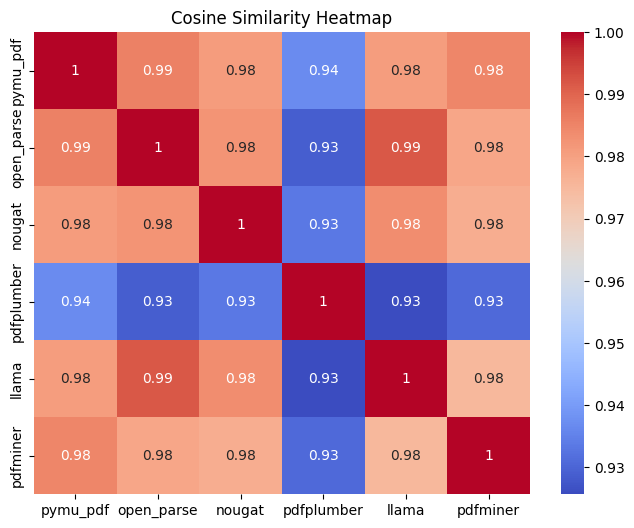

In [46]:
from sklearn.metrics.pairwise import cosine_similarity

# Example word embeddings (replace with your embeddings)
embeddings = {
    "pymu_pdf": parsers["pymupdf.txt"],
    "open_parse": parsers["openparse.txt"],
    "nougat": parsers["nougat.mmd"],
    "pdfplumber": parsers["pdfplumber.txt"],
    "llama": parsers["llama.md"],
    "pdfminer": parsers["pdfminer.txt"]
}

# Extract the embeddings as a list
embedding_values = list(embeddings.values())
words = list(embeddings.keys())

# Compute cosine similarity matrix
similarity_matrix = cosine_similarity(embedding_values)

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(similarity_matrix, annot=True, xticklabels=words, yticklabels=words, cmap='coolwarm')
plt.title('Cosine Similarity Heatmap')
plt.show()
